# calculate thresholds

to do
* higher res snow presence data source? maybe switch to HLS derived product?
* automatically choose target time based on some variable or other data source instead of guessing
* create inspect_area notebook to view S1, modis, SNOTEL SWE and temp TS per pixel

In [1]:
!pip -q install earthaccess

In [2]:
import pandas as pd
import glob
import create_dataset
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import os
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.colors import ListedColormap, BoundaryNorm


In [3]:
dataframes_folder = 'data/dataframes/'
fn = 'grandmesa_2023_tar_2023-06-01_ref_2023-06-01_2023-09-01_median_100.parquet'
fn = 'iceland_trollaskagi_peninsula_2023_tar_2023-06-01_ref_2023-06-01_2023-09-01_median_100.parquet'
fn = 'iceland_trollaskagi_peninsula_2015_tar_2015-06-27_ref_2015-01-01_2015-03-01_median_100.parquet'
fn = 'iceland_trollaskagi_peninsula_2015_tar_2015-06-27_ref_2015-01-01_2015-12-31_median_100.parquet'
fn = 'iceland_trollaskagi_peninsula_2015_tar_2015-06-27_ref_2015-01-01_2015-12-31_median_100.parquet'
fn = 'iceland_trollaskagi_peninsula_2015_tar_2015-06-27_ref_2015-01-01_2015-03-31_median_100.parquet'
#fn = 'grandmesa_2020_tar_2020-04-27_ref_2020-06-01_2020-07-31_median_100.parquet'
fn = 'grandmesa_2020_tar_2020-04-27_ref_2020-06-01_2020-07-31_median_30.parquet'


dataframe = pd.read_parquet(f'{dataframes_folder}{fn}')

all_files = glob.glob(os.path.join(dataframes_folder, "grandmesa*median_30.parquet"))
dataframe = pd.concat((pd.read_parquet(f) for f in all_files), ignore_index=True)

In [4]:
all_files

['data/dataframes/grandmesa_2016_tar_2016-04-27_ref_2016-06-01_2016-07-31_median_30.parquet',
 'data/dataframes/grandmesa_2018_tar_2018-04-27_ref_2018-06-01_2018-07-31_median_30.parquet',
 'data/dataframes/grandmesa_2020_tar_2020-04-27_ref_2020-06-01_2020-07-31_median_30.parquet',
 'data/dataframes/grandmesa_2015_tar_2015-04-27_ref_2015-06-01_2015-07-31_median_30.parquet',
 'data/dataframes/grandmesa_2022_tar_2022-04-27_ref_2022-06-01_2022-07-31_median_30.parquet',
 'data/dataframes/grandmesa_2019_tar_2019-04-27_ref_2019-06-01_2019-07-31_median_30.parquet',
 'data/dataframes/grandmesa_2017_tar_2017-04-27_ref_2017-06-01_2017-07-31_median_30.parquet',
 'data/dataframes/grandmesa_2023_tar_2023-04-27_ref_2023-06-01_2023-07-31_median_30.parquet',
 'data/dataframes/grandmesa_2021_tar_2021-04-27_ref_2021-06-01_2021-07-31_median_30.parquet']

In [5]:
dataframe = dataframe[dataframe['local_incidence_angle']<101]

In [6]:
ndsi_thresh =  40 #[30,70] # 40 #[40,60] #40 #[40,70]

In [7]:
dataframe = create_dataset.dataframe_ndsi_to_binary(dataframe,ndsi_thresh)

In [8]:
bins = [0,10,20,30,40,50,60,70,80,90,100]
labels = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100']


# Create bins for the 'local_incidence_angle' column
dataframe['local_incidence_angle_bins'] = pd.cut(dataframe['local_incidence_angle'], bins=bins, labels=labels)

dataframe['forest_cover_fraction_bins'] = pd.cut(dataframe['forest_cover_fraction'], bins=bins, labels=labels)

In [9]:
#dataframe.corr(numeric_only=True)

In [10]:
dataframe = create_dataset.dataframe_numbers_to_classes(dataframe)

In [11]:
parts = fn.split('_')
target_time = parts[parts.index('tar') + 1]

time_diff = (dataframe['time'] - pd.to_datetime(target_time)).abs()
mask = time_diff <= pd.Timedelta(days=10)

dataframe = dataframe[mask]

In [12]:
if type(dataframe['modis_binary'].iloc[0]) == str:
    pal = {'no snow':'peru','snow':'dodgerblue'} 
else:
    pal = {0:'peru',1:'dodgerblue'} 

In [13]:
def calculate_threshold_otsu(group):
    values = group['ratio_images'].values
    return threshold_otsu(values)


def calculate_threshold_logistic(group):
    X = group[['ratio_images']]
    y = group['modis_binary']
    
    if (len(np.unique(y)) == 2) & (y.value_counts().min()>50):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
        model = LogisticRegression(class_weight='balanced')
        model.fit(X_train, y_train)
        difference_array = np.absolute(0.5-model.predict_proba(X)[:,1])
        index = difference_array.argmin()
        thresh = X.values[index][0]
    else:
        thresh = np.nan 
        
    return thresh 

def calculate_roc_auc_logistic(group):
    X = group[['ratio_images']]
    y = group['modis_binary']
    
    if (len(np.unique(y)) == 2) & (y.value_counts().min()>50):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
        model = LogisticRegression(class_weight='balanced')
        model.fit(X_train, y_train)
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1],average='weighted') # add average
        
    else:
        auc = np.nan
    
    return auc


def calculate_accuracy_logistic(group):
    X = group[['ratio_images']]
    y = group['modis_binary']
    
    if (len(np.unique(y)) == 2) & (y.value_counts().min()>50):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
        model = LogisticRegression(class_weight='balanced')
        model.fit(X_train, y_train)
        acc = model.score(X_test,y_test)
    else:
        acc = np.nan
    
    return acc

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    #d = data.pivot(index=args[1], columns=args[0], values=args[2])
    pivot_table = data.pivot_table(values='val', index='forest_cover_fraction_bins', columns='local_incidence_angle_bins', dropna=False).sort_index(ascending=False, axis=0)
    ax = sns.heatmap(pivot_table, annot=True, cbar_ax=cbar_ax, vmin=df_vmin, vmax=df_vmax, fmt='.2f', **kwargs)
    return ax

## Let's use otsu thresholding and logistic regression to estimate optimal backscatter ratio thresholds to seperate snow from no snow. Let's first just assume the threshold changes as a function of local incidence angle bins.

In [14]:
thresholds_otsu = dataframe.groupby(
    ['sat:orbit_state','band','local_incidence_angle_bins']).apply(calculate_threshold_otsu).reset_index().rename({0:'val'},axis='columns') 

In [15]:
thresholds_logistic = dataframe.groupby(
    ['sat:orbit_state','band','local_incidence_angle_bins']).apply(calculate_threshold_logistic).reset_index().rename({0:'val'},axis='columns')

## Let's visualize these thresholds on top of the backscatter ratio boxplots grouped by snow presence.

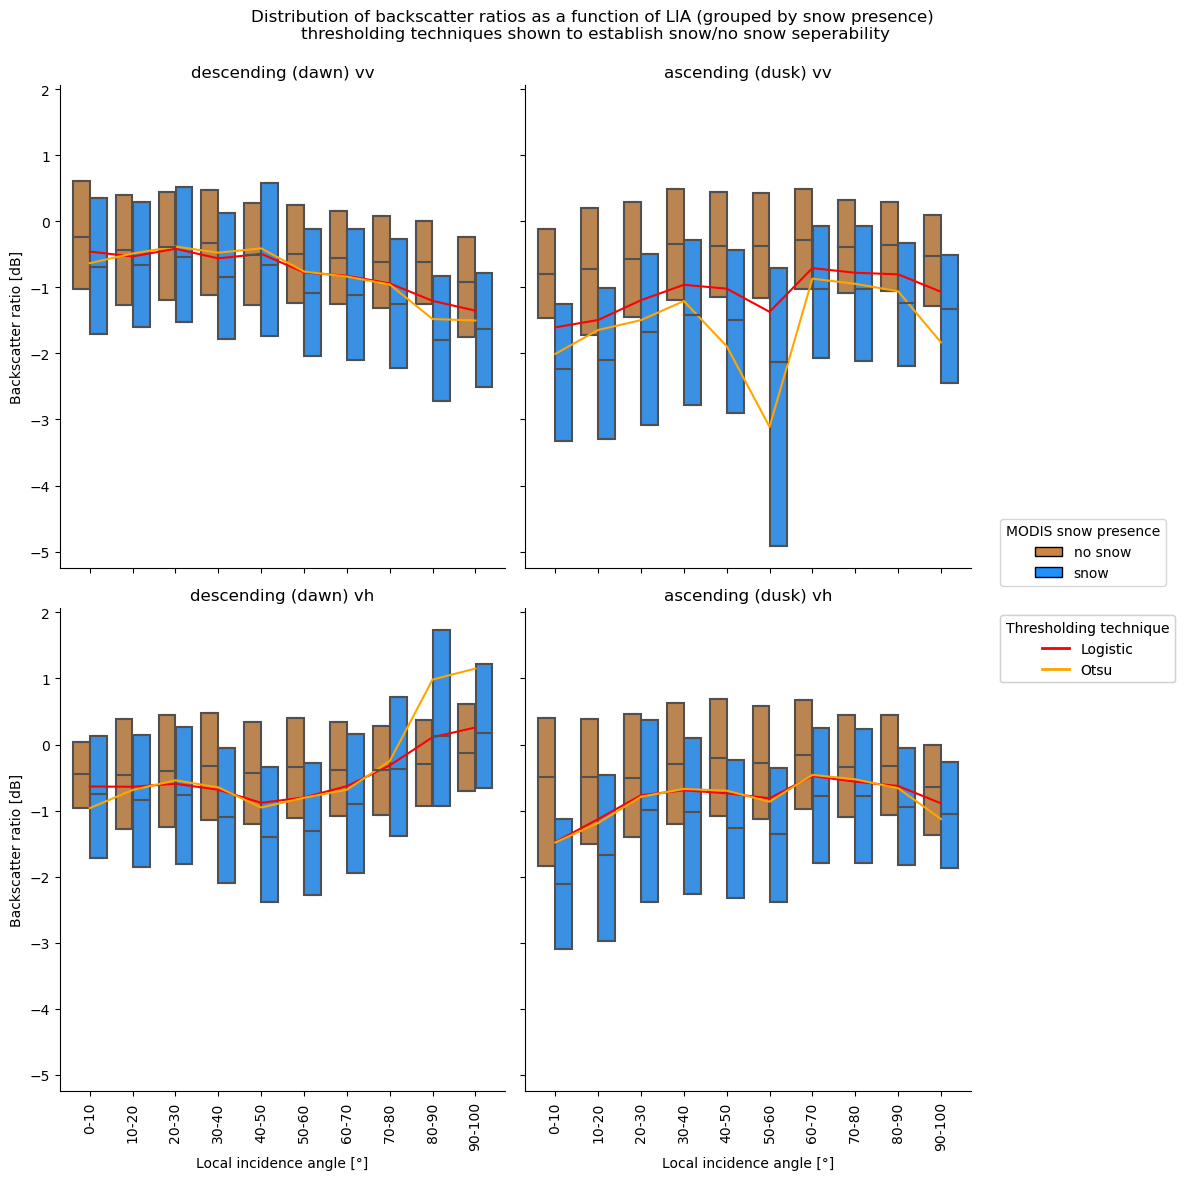

In [16]:
g = sns.catplot(x='local_incidence_angle_bins', y='ratio_images', hue="modis_binary", data=dataframe,
               row="band", col='sat:orbit_state', col_order=['descending','ascending'], kind='box', showfliers=False, whis=0, palette=pal, height=6, legend_out=False)

row_values = dataframe['band'].unique()
col_values = dataframe['sat:orbit_state'].unique()[::-1]
row_indices = {value: i for i, value in enumerate(row_values)}
col_indices = {value: i for i, value in enumerate(col_values)}


for ax, ((row_value, col_value), _) in zip(g.axes.flat, g.axes_dict.items()):
    row_index = row_indices[row_value]
    col_index = col_indices[col_value]
        
    sns.lineplot(thresholds_logistic[(thresholds_logistic['sat:orbit_state'] == col_value) & (thresholds_logistic['band'] == row_value)],
                    x="local_incidence_angle_bins", y='val', color='red', label='Logistic', ax=g.facet_axis(row_index, col_index))
    sns.lineplot(thresholds_otsu[(thresholds_otsu['sat:orbit_state'] == col_value) & (thresholds_otsu['band'] == row_value)],
                    x="local_incidence_angle_bins", y='val', color='orange', label='Otsu', ax=g.facet_axis(row_index, col_index))
        
    ax.get_legend().remove()
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('Backscatter ratio [dB]')
    ax.set_xlabel('Local incidence angle [\N{degree sign}]')
    dawn_or_dusk = 'dawn' if col_value == 'descending' else 'dusk'
    ax.set_title(f'{col_value} ({dawn_or_dusk}) {row_value}')

box_legend = [patches.Patch(facecolor=color, edgecolor='black', label=label) for label, color in zip(g._legend_data.keys(), pal.values())]
box_legend = plt.legend(handles=box_legend, bbox_to_anchor=(1.05, 1.2), loc='upper left')
box_legend.set_title('MODIS snow presence')

# Create a custom legend for the line plots
line_legend = [lines.Line2D([0], [0], color=color, lw=2, label=label) for color, label in zip(['red', 'orange'], ['Logistic', 'Otsu'])]
line_legend = plt.legend(handles=line_legend, bbox_to_anchor=(1.05, 1), loc='upper left')
line_legend.set_title('Thresholding technique')

# Add the legends to the figure
g.fig.add_artist(box_legend)
g.fig.add_artist(line_legend)

g.fig.suptitle('Distribution of backscatter ratios as a function of LIA (grouped by snow presence) \nthresholding techniques shown to establish snow/no snow seperability\n')
g.tight_layout()

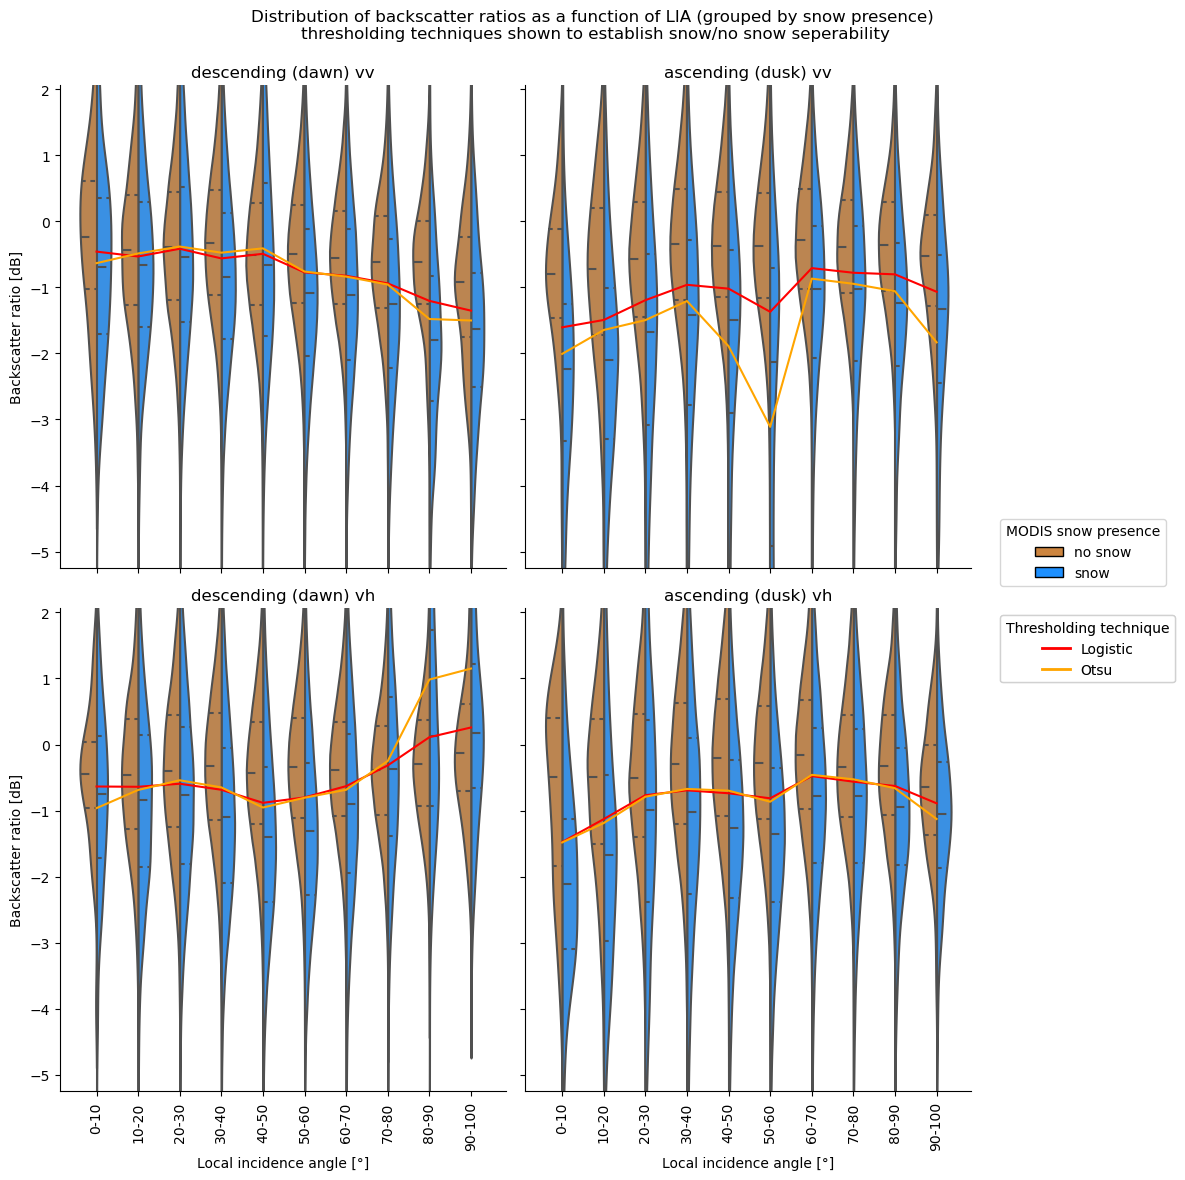

In [17]:
g = sns.catplot(x='local_incidence_angle_bins', y='ratio_images', hue="modis_binary", data=dataframe,
               row="band", col='sat:orbit_state', col_order=['descending','ascending'], kind='violin',split=True,inner='quart', palette=pal, height=6, legend_out=False)

row_values = dataframe['band'].unique()
col_values = dataframe['sat:orbit_state'].unique()[::-1]
row_indices = {value: i for i, value in enumerate(row_values)}
col_indices = {value: i for i, value in enumerate(col_values)}


for ax, ((row_value, col_value), _) in zip(g.axes.flat, g.axes_dict.items()):
    row_index = row_indices[row_value]
    col_index = col_indices[col_value]
        
    sns.lineplot(thresholds_logistic[(thresholds_logistic['sat:orbit_state'] == col_value) & (thresholds_logistic['band'] == row_value)],
                    x="local_incidence_angle_bins", y='val', color='red', label='Logistic', ax=g.facet_axis(row_index, col_index))
    sns.lineplot(thresholds_otsu[(thresholds_otsu['sat:orbit_state'] == col_value) & (thresholds_otsu['band'] == row_value)],
                    x="local_incidence_angle_bins", y='val', color='orange', label='Otsu', ax=g.facet_axis(row_index, col_index))
        
    ax.get_legend().remove()
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('Backscatter ratio [dB]')
    ax.set_xlabel('Local incidence angle [\N{degree sign}]')
    dawn_or_dusk = 'dawn' if col_value == 'descending' else 'dusk'
    ax.set_title(f'{col_value} ({dawn_or_dusk}) {row_value}')

box_legend = [patches.Patch(facecolor=color, edgecolor='black', label=label) for label, color in zip(g._legend_data.keys(), pal.values())]
box_legend = plt.legend(handles=box_legend, bbox_to_anchor=(1.05, 1.2), loc='upper left')
box_legend.set_title('MODIS snow presence')

# Create a custom legend for the line plots
line_legend = [lines.Line2D([0], [0], color=color, lw=2, label=label) for color, label in zip(['red', 'orange'], ['Logistic', 'Otsu'])]
line_legend = plt.legend(handles=line_legend, bbox_to_anchor=(1.05, 1), loc='upper left')
line_legend.set_title('Thresholding technique')

# Add the legends to the figure
g.fig.add_artist(box_legend)
g.fig.add_artist(line_legend)

g.fig.suptitle('Distribution of backscatter ratios as a function of LIA (grouped by snow presence) \nthresholding techniques shown to establish snow/no snow seperability\n')
g.tight_layout()

## Now assume thresholds change as a function of local incidence angle and forest cover fraction. Let's see how logistic regression derived backscatter ratio thresholds change as a function of LIA and FCF.

In [18]:
thresholds_logistic = dataframe.groupby(
    ['sat:orbit_state','band','local_incidence_angle_bins','forest_cover_fraction_bins'],dropna=False
).apply(calculate_threshold_logistic).reset_index().rename({0:'val'},axis='columns') 

/srv/conda/envs/notebook/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


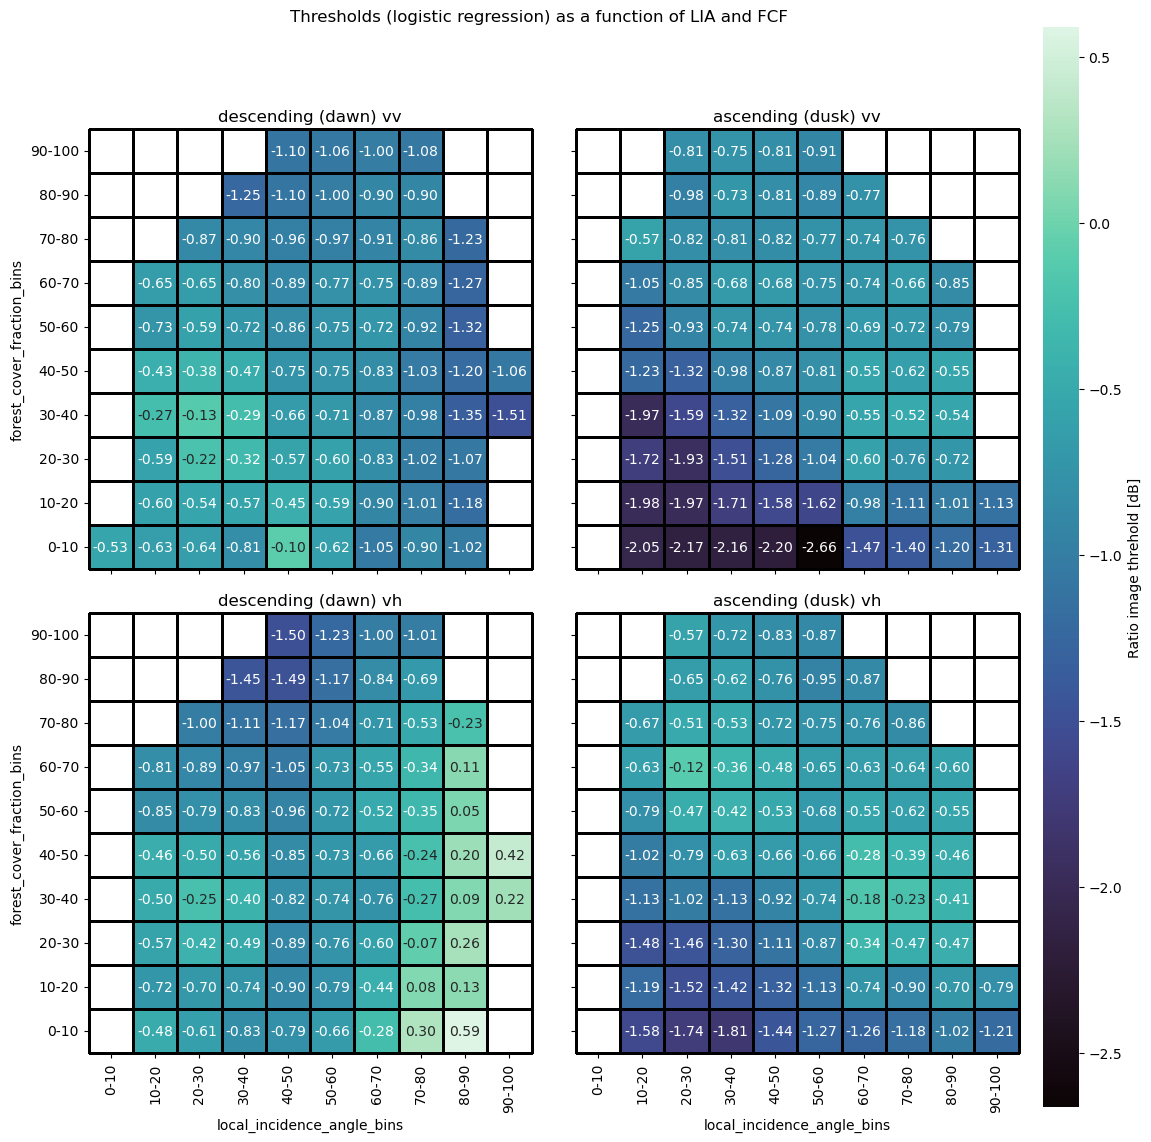

In [19]:
df = thresholds_logistic
df_vmin = df['val'].min()
df_vmax = df['val'].max()

g = sns.FacetGrid(df, row="band", col="sat:orbit_state", col_order= ['descending','ascending'], row_order=['vv','vh'], legend_out=True, height=6, aspect=1, gridspec_kws={"wspace":0.1,"hspace":0.1})
cbar_ax = g.fig.add_axes([.92, .065, .03, .9])
    
g.map_dataframe(draw_heatmap, cmap=sns.color_palette(palette='mako',as_cmap=True), linewidths=1, linecolor='black', clip_on=False)
g.fig.suptitle('Thresholds (logistic regression) as a function of LIA and FCF')

cbar = g.axes.flat[0].collections[0].colorbar
cbar.set_label('Ratio image threhold [dB]')

for ax, ((row_value, col_value), _) in zip(g.axes.flat, g.axes_dict.items()):
    dawn_or_dusk = 'dawn' if col_value == 'descending' else 'dusk'
    ax.set_title(f'{col_value} ({dawn_or_dusk}) {row_value}')
    ax.tick_params(axis='x', rotation=90)

g.tight_layout()

## Now let's check how the accuracy of logistic regression derived backscatter ratio thresholds change as a function of LIA and FCF.

In [20]:
accuracy_logistic = dataframe.groupby(
    ['sat:orbit_state','band','local_incidence_angle_bins','forest_cover_fraction_bins'],dropna=False
).apply(calculate_accuracy_logistic).reset_index().rename({0:'val'},axis='columns') 

/srv/conda/envs/notebook/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


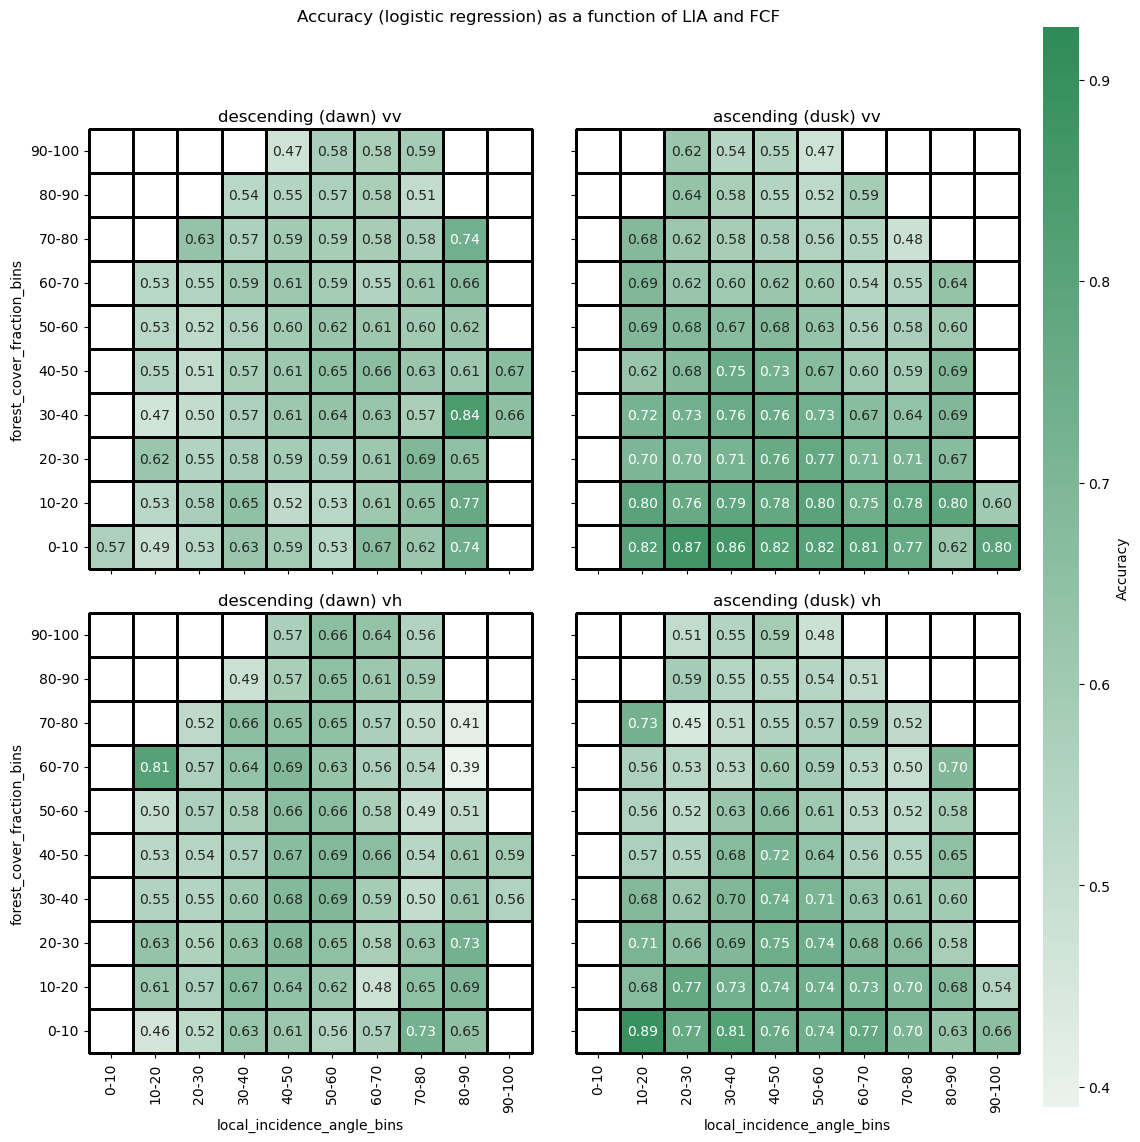

In [21]:
df = accuracy_logistic
df_vmin = df['val'].min()
df_vmax = df['val'].max()

g = sns.FacetGrid(df, row="band", col="sat:orbit_state", col_order= ['descending','ascending'], row_order=['vv','vh'], legend_out=True, height=6, aspect=1, gridspec_kws={"wspace":0.1,"hspace":0.1})
cbar_ax = g.fig.add_axes([.92, .065, .03, .9])
    
g.map_dataframe(draw_heatmap, cmap=sns.light_palette("seagreen", as_cmap=True), linewidths=1, linecolor='black', clip_on=False)
g.fig.suptitle('Accuracy (logistic regression) as a function of LIA and FCF')

cbar = g.axes.flat[0].collections[0].colorbar
cbar.set_label('Accuracy')

for ax, ((row_value, col_value), _) in zip(g.axes.flat, g.axes_dict.items()):
    dawn_or_dusk = 'dawn' if col_value == 'descending' else 'dusk'
    ax.set_title(f'{col_value} ({dawn_or_dusk}) {row_value}')
    
g.tight_layout()
#g.fig.subplots_adjust(right=0.9)

## And finally a more robust measure: see how ROC AUC of logistic regression derived backscatter ratio thresholds change as a function of LIA and FCF. This is a better way to evaluate our thresholding because it is not as biased to imbalanced snow presence class size. More [here](https://datascience.stackexchange.com/questions/806/advantages-of-auc-vs-standard-accuracy). 

For interpretation, here is a rough guide from [Applied Logistic Regression](https://onlinelibrary.wiley.com/doi/book/10.1002/9781118548387):
- 0.5-0.7 = poor discrimination
- 0.7-0.8 = acceptable discrimination
- 0.8-0.9 = excellent discrimination
- \>0.9 = outstanding discrimination

In [22]:
roc_auc_logistic = dataframe.groupby(
    ['sat:orbit_state','band','local_incidence_angle_bins','forest_cover_fraction_bins'],dropna=True
).apply(calculate_roc_auc_logistic).reset_index().rename({0:'val'},axis='columns') 

/srv/conda/envs/notebook/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


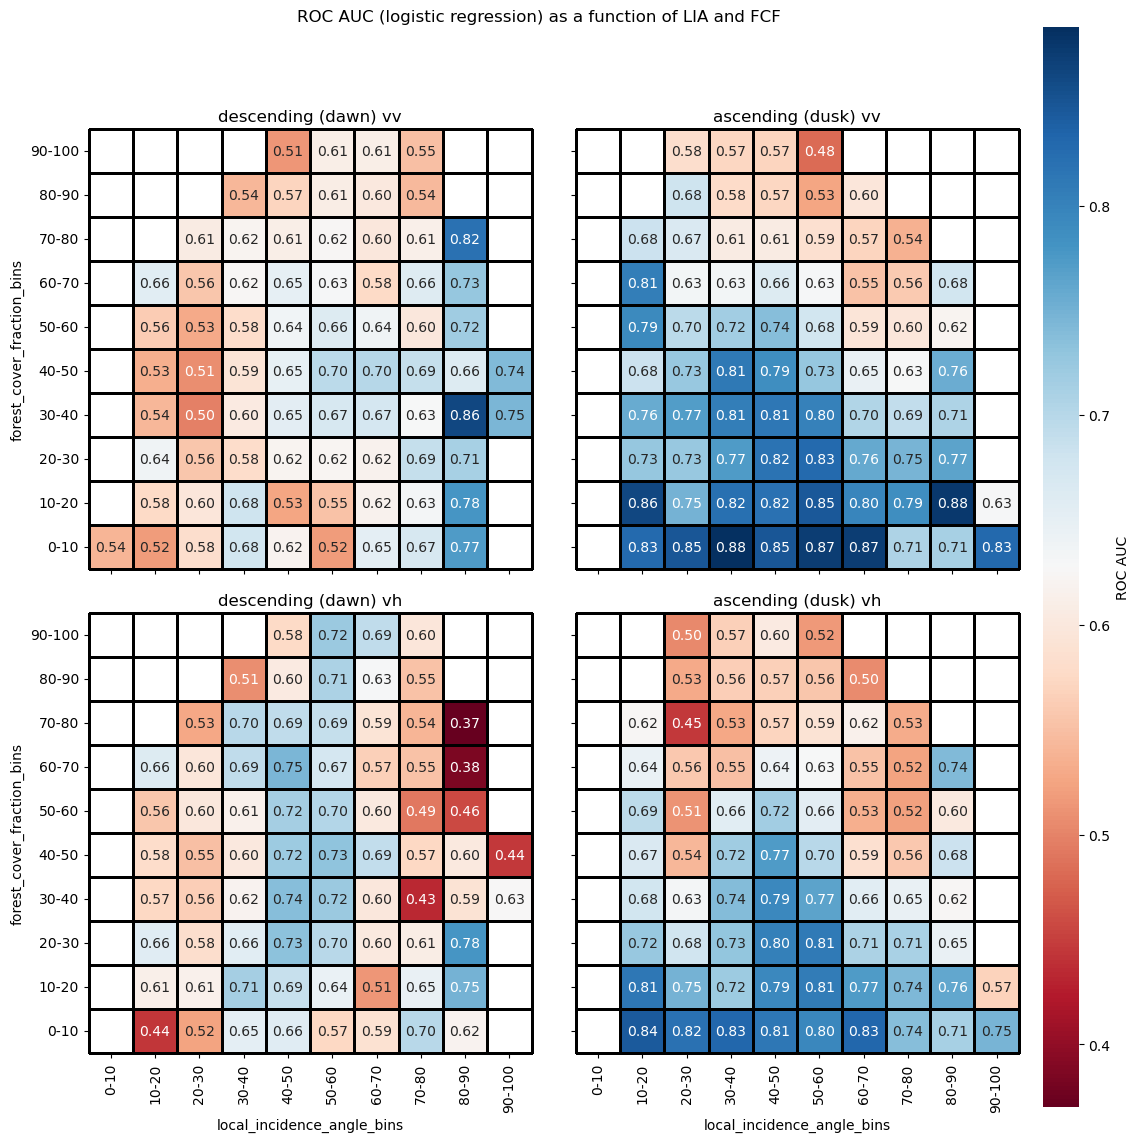

In [23]:
df = roc_auc_logistic
df_vmin = df['val'].min()
df_vmax = df['val'].max()

g = sns.FacetGrid(df, col="sat:orbit_state", row="band", col_order= ['descending','ascending'], row_order=['vv','vh'], legend_out=True, height=6, aspect=1, gridspec_kws={"wspace":0.1,"hspace":0.1})
cbar_ax = g.fig.add_axes([.92, .065, .03, .9])
    
g.map_dataframe(draw_heatmap, cmap='RdBu', linewidths=1, linecolor='black', clip_on=False)
g.fig.suptitle('ROC AUC (logistic regression) as a function of LIA and FCF')

cbar = g.axes.flat[0].collections[0].colorbar
cbar.set_label('ROC AUC')

for ax, ((row_value, col_value), _) in zip(g.axes.flat, g.axes_dict.items()):
    dawn_or_dusk = 'dawn' if col_value == 'descending' else 'dusk'
    ax.set_title(f'{col_value} ({dawn_or_dusk}) {row_value}')

    
    
g.tight_layout()
#g.fig.subplots_adjust(right=0.9)

/srv/conda/envs/notebook/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


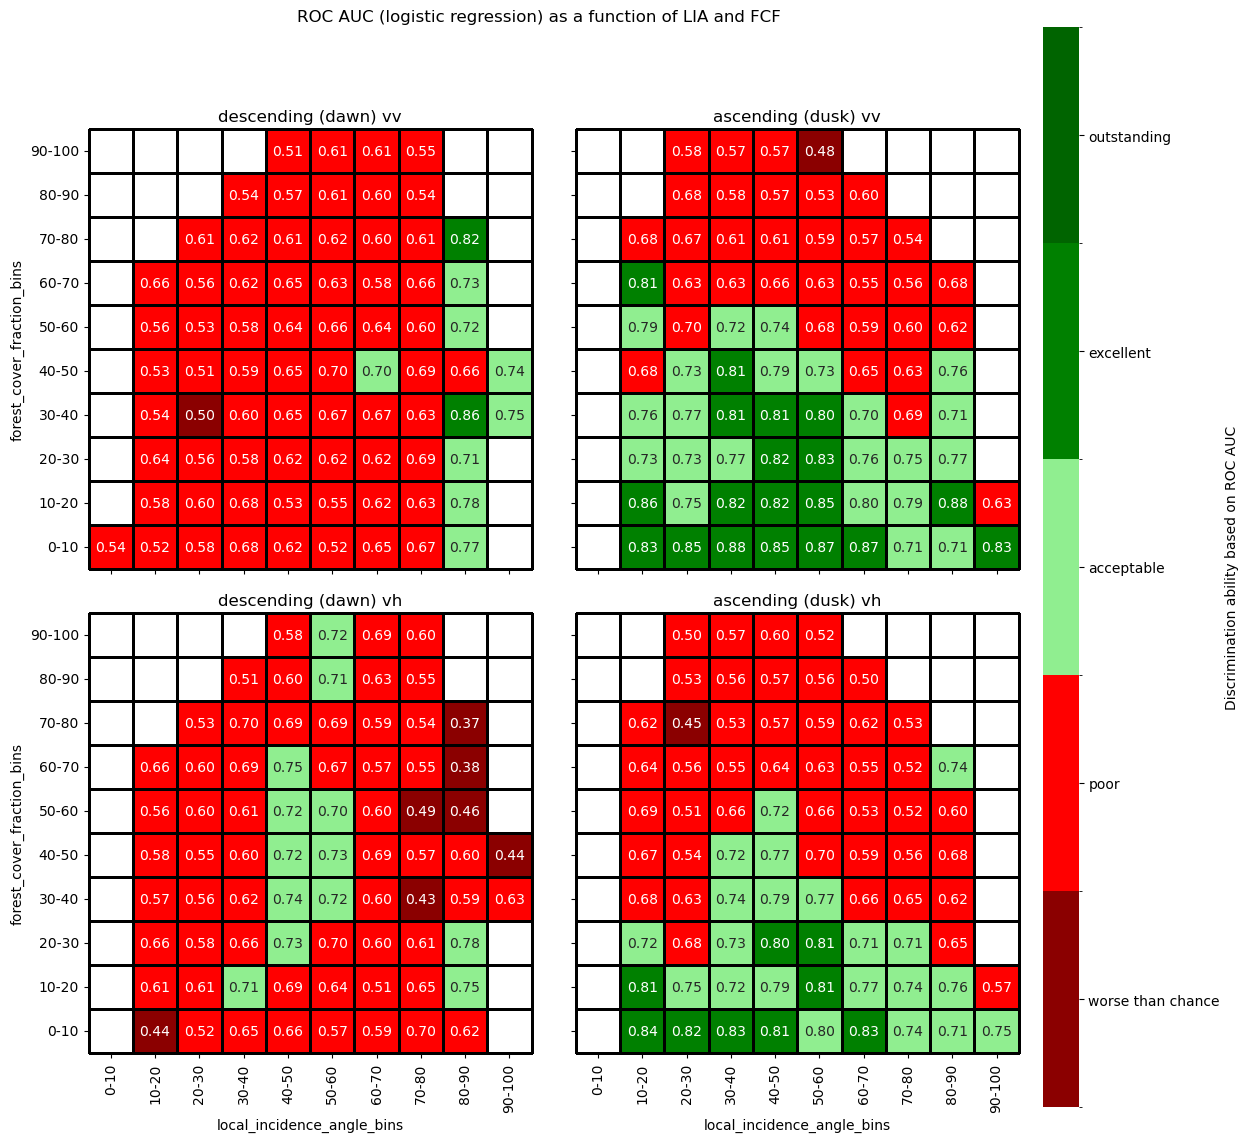

In [24]:
df = roc_auc_logistic
df_vmin = df['val'].min()
df_vmax = df['val'].max()

colors = ["darkred", "red", "lightgreen", "green", "darkgreen"]
cmap = ListedColormap(colors)
ranges = [0.0, 0.5, 0.7, 0.8, 0.9, 1.0]
norm = BoundaryNorm(ranges, cmap.N)

g = sns.FacetGrid(df, col="sat:orbit_state", row="band", col_order= ['descending','ascending'], row_order=['vv','vh'], legend_out=True, height=6, aspect=1, gridspec_kws={"wspace":0.1,"hspace":0.1})
cbar_ax = g.fig.add_axes([.92, .065, .03, .9])
    
g.map_dataframe(draw_heatmap, cmap=cmap, norm=norm, linewidths=1, linecolor='black', clip_on=False)
g.fig.suptitle('ROC AUC (logistic regression) as a function of LIA and FCF')

cbar = g.axes.flat[0].collections[0].colorbar
cbar.set_label('Discrimination ability based on ROC AUC')
cbar.set_ticks(ticks=[0.25, .6, .75, .85, .95], labels=['worse than chance', 'poor', 'acceptable', 'excellent', 'outstanding'])

for ax, ((row_value, col_value), _) in zip(g.axes.flat, g.axes_dict.items()):
    dawn_or_dusk = 'dawn' if col_value == 'descending' else 'dusk'
    ax.set_title(f'{col_value} ({dawn_or_dusk}) {row_value}')

    

g.tight_layout()
#g.fig.subplots_adjust(right=0.9)

## So let's analyze these ROC AUC values to answer: do VV or VH backscatter ratio thresholds provide better wet snow seperability?

In [25]:
idx_asc = roc_auc_logistic[roc_auc_logistic.iloc[:,0]=='ascending'].groupby(['local_incidence_angle_bins','forest_cover_fraction_bins'])['val'].idxmax().dropna()
idx_desc = roc_auc_logistic[roc_auc_logistic.iloc[:,0]=='descending'].groupby(['local_incidence_angle_bins','forest_cover_fraction_bins'])['val'].idxmax().dropna()

In [26]:
roc_auc_logistic['band_int'] = roc_auc_logistic['band'].apply(lambda x: 0 if x == 'vv' else 1)

In [27]:
roc_auc_logistic_best_asc = roc_auc_logistic.loc[idx_asc]
roc_auc_logistic_best_desc = roc_auc_logistic.loc[idx_desc]

/tmp/ipykernel_2874/3018184264.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


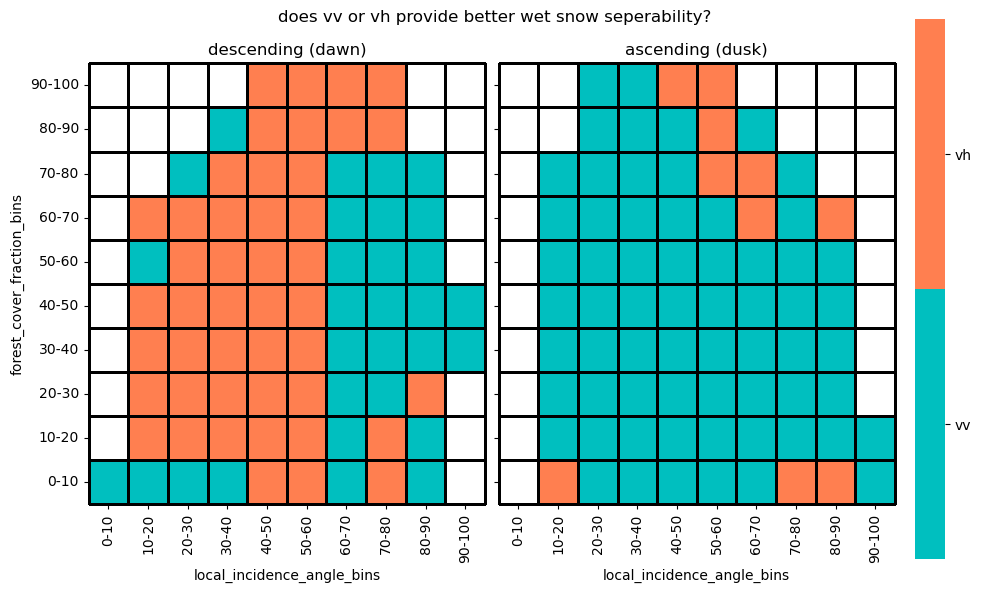

In [29]:
f, axs = plt.subplots(1,2,figsize=(10, 6), sharey=True, subplot_kw={'adjustable':'box'})

cmap = ListedColormap(['c', 'coral'])

pivot_table_asc = roc_auc_logistic_best_asc.pivot_table(values='band_int', index='forest_cover_fraction_bins', columns='local_incidence_angle_bins', dropna=False).sort_index(ascending=False, axis=0)
pivot_table_desc = roc_auc_logistic_best_desc.pivot_table(values='band_int', index='forest_cover_fraction_bins', columns='local_incidence_angle_bins', dropna=False).sort_index(ascending=False, axis=0)

colorbar_ax = f.add_axes([.92, .065, .03, .9])
heatmap1 = sns.heatmap(pivot_table_desc, cmap=cmap, ax=axs[0], cbar=False, linewidths=1, linecolor='black', clip_on=False)
heatmap2 = sns.heatmap(pivot_table_asc, cmap=cmap, ax=axs[1], cbar_ax=colorbar_ax, linewidths=1, linecolor='black',clip_on=False)
cbar = f.axes[1].collections[0].colorbar
cbar.set_ticks([0.25, 0.75])
axs[0].set_title(f'descending (dawn)')
axs[1].set_title(f'ascending (dusk)')
axs[1].set_ylabel('')
axs[0].tick_params(axis='y', rotation=0)
cbar.set_ticklabels(['vv', 'vh'])
f.suptitle('does vv or vh provide better wet snow seperability?')
f.tight_layout()
f.subplots_adjust(right=0.9)